###Connet to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/competition

Mounted at /gdrive
/gdrive/My Drive/competition


###Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [ ]:
# Import other libraries
import cv2
#from tensorflow.keras.applications.mobilenet import preprocess_input
#from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

###Load cleaned dataset

In [ ]:
#load dataset
load_data = np.load('balanced_dataset_v1.npz', allow_pickle=True)

images = np.array(load_data['data'])#.astype(np.uint8))
y = np.array(load_data['labels'])
labels = {'healthy':0, 'unhealthy':1}

#normalize images
#images = images[:] / 255

In [ ]:
images.shape

(6202, 96, 96, 3)

In [ ]:
y.shape

(6202,)

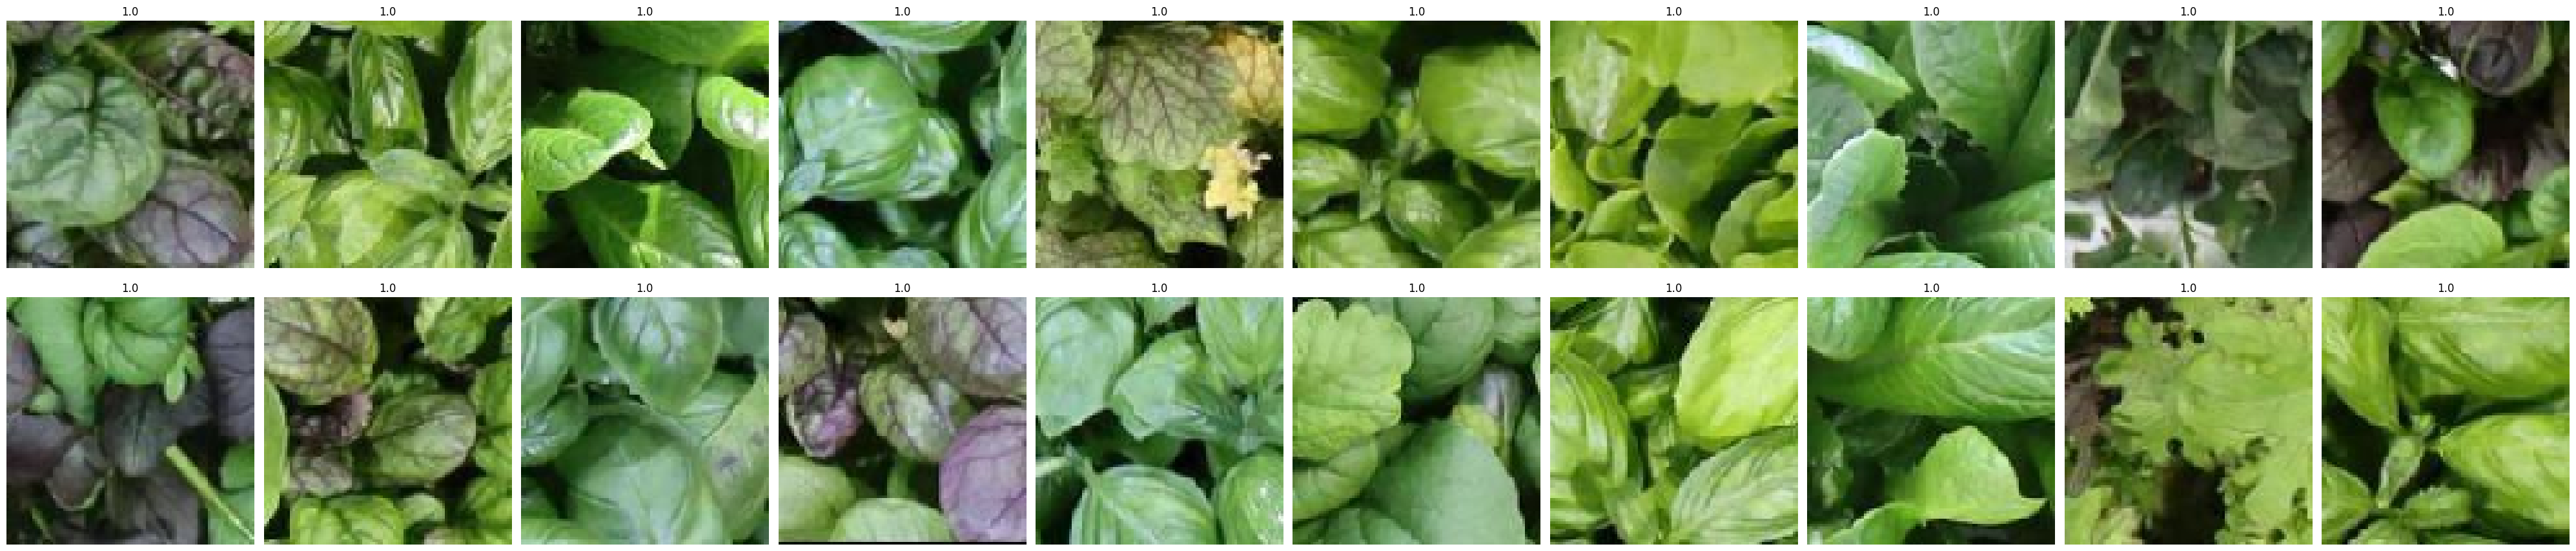

In [ ]:
# Number of images to display
num_img = 20
shift = 1000
# Create subplots for displaying items
fig, axes = plt.subplots(2, num_img//2, figsize=(40, 9))
for i in range(num_img):
    ax = axes[i%2, i%num_img//2]
    ax.imshow(np.clip(images[i+shift], 0, 255))  # Display clipped item images
    ax.set_title(f'{y[i+shift]}')
    ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# Inspect the target
print('Counting occurrences of target classes:')
print(pd.DataFrame(y, columns=['status'])['status'].value_counts())

Counting occurrences of target classes:
1.0    3101
0.0    3101
Name: status, dtype: int64


In [ ]:
labels.keys()

dict_keys(['healthy', 'unhealthy'])

In [ ]:
#transform labels in binary values
#for key in labels.keys():
#  y[y==key] = labels[key]

In [ ]:
# Convert labels to categorical format using one-hot encoding
#y_cat = tfk.utils.to_categorical(y)

# Split data into training and validation sets, maintaining class distribution
X_train, X_val, y_train, y_val = train_test_split(images, y, random_state=seed, test_size=0.2, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, random_state=seed, test_size=0.2, stratify=y_train)

del images
del y
#del y_cat

In [ ]:
# Print the shapes of the resulting datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)
print("Test Data Shape:", X_test.shape)
print("Test Label Shape:", y_test.shape)

Training Data Shape: (3968, 96, 96, 3)
Training Label Shape: (3968,)
Validation Data Shape: (1241, 96, 96, 3)
Validation Label Shape: (1241,)
Test Data Shape: (993, 96, 96, 3)
Test Label Shape: (993,)


In [ ]:
# Compare categorical label and "default" label representation
print('Categorical label:', y_train[0])           # Display the categorical label
print('"Default" label:', np.argmax(y_train[0]))   # Display the equivalent numeric label

Categorical label: 1.0
"Default" label: 0


## Create couples of images

In [ ]:
def create_couples(X, y,dim_dataset=3000):

    left_images = []
    right_images = []
    batch_labels = []


    for _ in range(dim_dataset):
        # Randomly select two different indices for the pair
        index1, index2 = np.random.choice(X.shape[0]-1, size=2, replace=False)

        left_images.append(X[index1])
        right_images.append(X[index2])

        # Labels: 1 if images are from the same class, 0 otherwise
        batch_labels.append(1 if y[index1] == y[index2] else 0)

    return [np.array(left_images), np.array(left_images)], np.array(batch_labels)

In [ ]:
#load dataset
load_data = np.load('balanced_dataset_v1.npz', allow_pickle=True)

X = np.array(load_data['data'])#.astype(np.uint8))
y = np.array(load_data['labels'])
labels = {'healthy':0, 'unhealthy':1}

#normalize images
#images = images[:] / 255

In [ ]:
couples , couple_label = create_couples(X,y)

In [ ]:
saving = True

if saving is True:
  output_npz = "couples_dataset_v1.npz"

  np.savez(output_npz, data = couples, labels = couple_label)

##Siamese network

In [ ]:
#load dataset
load_data = np.load('couples_dataset_v1.npz', allow_pickle=True)

images = np.array(load_data['data'])#.astype(np.uint8))
y = np.array(load_data['labels'])
labels = {'healthy':0, 'unhealthy':1}

left_images = images[0]
right_images = images[0]
del images

#normalize images
#images = images[:] / 255

In [ ]:
# Split data into training and validation sets, maintaining class distribution
X_left_train, X_left_val, X_right_train, X_right_val, y_train, y_val = train_test_split(left_images, right_images, y, random_state=seed, test_size=0.2, stratify=y)
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, random_state=seed, test_size=0.2, stratify=y_train)

del left_images
del right_images
del y

In [ ]:
X_left_train.shape,X_right_train.shape,X_left_val.shape,X_right_val.shape

((2400, 96, 96, 3), (2400, 96, 96, 3), (600, 96, 96, 3), (600, 96, 96, 3))

In [ ]:
y_train.shape, y_val.shape

((2400,), (600,))

In [ ]:
# Define key model parameters
input_shape = X_left_train.shape[1:]  # Input shape for the model
output_shape = 1  # Output shape for the model
epochs = 2000                     # Number of training epochs
lr = 1e-2
batch_size = 256
dim = 128

In [ ]:
def contrastive_loss(y_true, y_pred):
    margin = 1.0
    y_true = tf.cast(y_true, tf.float32)
    return tf.reduce_mean(y_true * tf.square(y_pred) + (1.0 - y_true) * tf.square(tf.maximum(margin - y_pred, 0.0)))

In [ ]:
def contrastive_loss2(y_true, y_pred):
    margin = 1.0
    y_true = tf.cast(y_true, tf.float32)
    return tf.reduce_mean( (1.0-y_true) * tf.square(y_pred) + (y_true) * tf.square(tf.maximum(margin - y_pred, 0.0)))

In [ ]:
#from tensorflow.keras.applications.resnet50 import preprocess_input
#from tensorflow.keras.applications.convnext import preprocess_input
from tensorflow.keras.applications.efficientnet import preprocess_input

In [ ]:
def build_snn(input_shape=input_shape, output_shape=output_shape, emb_dim = 256, learning_rate=10e-4, seed=seed, drop_rate = 0.2,l2_lambda= 1e-4):

    #Preprocessing layers
    augmentation = tf.keras.Sequential([
        tfkl.RandomBrightness(0.2, value_range=(0,1)),
        tfkl.RandomTranslation(0.2,0.2),
        tfkl.RandomFlip("horizontal_and_vertical"),
        tfkl.RandomRotation(0.2),
        tfkl.RandomZoom(0.2),
        tfkl.RandomContrast(0.75)
    ], name='augmentation')

    #Projection net
    projection_net = tf.keras.Sequential([
      tfkl.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(l2_lambda), kernel_initializer=tfk.initializers.HeUniform(seed=seed), name='projection_layer1'),
      tfkl.BatchNormalization(name='BatchNorm_proj_1'),
      tfkl.Activation('relu'),
      tfkl.Dropout(drop_rate),
      tfkl.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(l2_lambda), kernel_initializer=tfk.initializers.HeUniform(seed=seed), name='projection_layer2'),
      tfkl.BatchNormalization(name='BatchNorm_proj_2'),
      tfkl.Activation('relu'),
      tfkl.Dropout(drop_rate),
      tfkl.Dense(emb_dim, activation='linear', kernel_regularizer=tf.keras.regularizers.l2(l2_lambda), kernel_initializer=tfk.initializers.HeUniform(seed=seed), name='projection_layer3')
    ], name='projection_net')

    #projection_head = tfkl.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_lambda), name='projection_layer')

    # Load a pretrained model (e.g., ResNet)
    pretrained_model = tf.keras.applications.EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(96, 96, 3),
        pooling='avg'
        )
    pretrained_model.trainable = False

    #x0 left branch, x1 right branch
    left_input = tfk.Input(shape=input_shape)
    right_input = tfk.Input(shape=input_shape)

    #x0 = augmentation(left_input)
    #x1 = augmentation(right_input)

    x0 = pretrained_model(left_input)
    x1 = pretrained_model(right_input)

    #x0 = tfkl.BatchNormalization()(x0)
    #x1 = tfkl.BatchNormalization()(x1)
    x0 = tfkl.LayerNormalization()(x0)
    x1 = tfkl.LayerNormalization()(x1)

    #Dropout for regularization
    #x0 = tfkl.Dropout(drop_rate)(x0)
    #x1 = tfkl.Dropout(drop_rate)(x1)

    #Project extracted features
    x0_proj = projection_net(x0)
    x1_proj = projection_net(x1)

    #x0_proj = tfkl.BatchNormalization()(x0_proj)
    #x1_proj = tfkl.BatchNormalization()(x1_proj)
    x0_proj = tfkl.LayerNormalization()(x0_proj)
    x1_proj = tfkl.LayerNormalization()(x1_proj)

    #Calculate Euclidean distance between the projections
    distance_layer = tfkl.Lambda(lambda x: tf.norm(x[0] - x[1], axis=1, keepdims=True))([x0_proj, x1_proj])
    #output_layer = tfkl.Dense(units=1, activation='sigmoid',  kernel_initializer=tfk.initializers.GlorotUniform(seed=seed), name='output_layer')(distance_layer)

    #Define the Siamese model
    siamese_model = tfk.Model(inputs=[left_input, right_input], outputs=distance_layer)

    #Compile the model with contrastive loss and train it
    optimizer = tfk.optimizers.AdamW(learning_rate)#, weight_decay=5e-4)
    #loss = tfk.losses.BinaryCrossentropy()
    #loss = tfk.losses.Hinge()
    #metrics = ['accuracy']
    siamese_model.compile(loss=contrastive_loss2, optimizer=optimizer)

    return siamese_model

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 input_9 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 efficientnetb0 (Functional  (None, 1280)                 4049571   ['input_8[0][0]',             
 )                                                                   'input_9[0][0]']             
                                                                                                  
 layer_normalization_8 (Lay  (None, 1280)                 2560      ['efficientnetb0[0][0]']

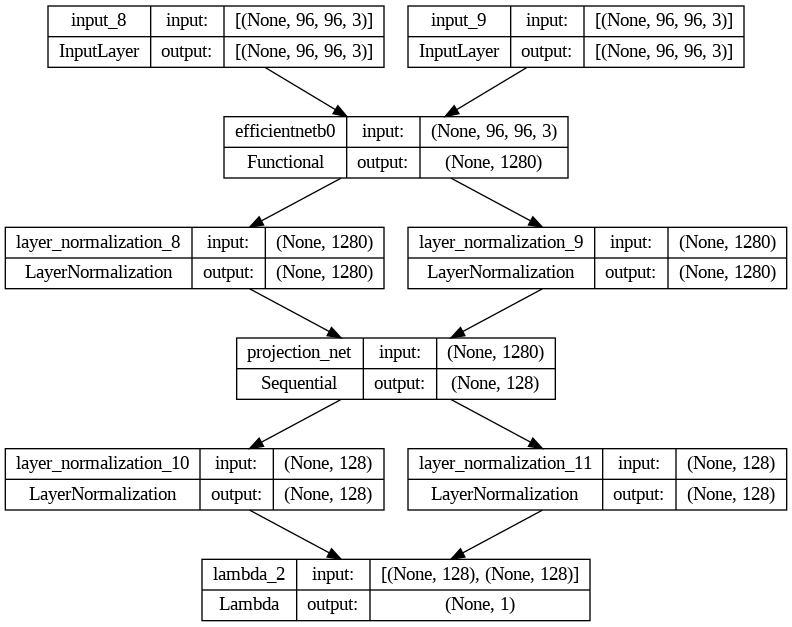

In [ ]:
snn_model = build_snn(emb_dim=dim)
snn_model.summary()
tfk.utils.plot_model(snn_model, show_shapes=True)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True)

lr_patience = 5
lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss',# Metric to monitor (validation mean squared error in this case)
    patience=lr_patience,  # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.8,            # Factor by which the learning rate will be reduced (0.9 in this case)
    mode='min',            # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
    min_lr=1e-6            # Minimum learning rate
)

In [ ]:
X_right_val.shape

(600, 96, 96, 3)

In [ ]:
#Train embedding model
snn_history = snn_model.fit(
    x =[preprocess_input(X_left_train*255.), preprocess_input(X_right_train*255.)],
    y = y_train,
    batch_size = batch_size,
    epochs = 2000,
    validation_data = ([preprocess_input(X_left_val*255.),preprocess_input(X_right_val*255.)], y_val),
    callbacks = [early_stopping]
).history

Epoch 1/2000
10/10 [==============================] - 24s 757ms/step - loss: 38.4926 - val_loss: 0.5852
Epoch 2/2000
10/10 [==============================] - 3s 272ms/step - loss: 13.3567 - val_loss: 0.5806
Epoch 3/2000
10/10 [==============================] - 3s 260ms/step - loss: 7.6138 - val_loss: 0.5944
Epoch 4/2000
10/10 [==============================] - 3s 259ms/step - loss: 5.2871 - val_loss: 0.6082
Epoch 5/2000
10/10 [==============================] - 2s 248ms/step - loss: 4.2044 - val_loss: 0.6171
Epoch 6/2000
10/10 [==============================] - 3s 275ms/step - loss: 3.5404 - val_loss: 0.6237
Epoch 7/2000
10/10 [==============================] - 3s 263ms/step - loss: 3.0913 - val_loss: 0.6233
Epoch 8/2000
10/10 [==============================] - 2s 247ms/step - loss: 2.7446 - val_loss: 0.6233
Epoch 9/2000
10/10 [==============================] - 3s 263ms/step - loss: 2.4957 - val_loss: 0.6271
Epoch 10/2000
10/10 [==============================] - 2s 250ms/step - loss: 2.

In [ ]:
for layer in snn_model.layers:
  print(layer.trainable, layer.name)

True input_17
True input_18
False efficientnetb0
True layer_normalization_20
True layer_normalization_21
True projection_net
True layer_normalization_22
True layer_normalization_23
True lambda_5


## Check high-dimensional embeddings

In [ ]:
snn_model.trainable = False
for layer in snn_model.layers:
  print(layer.trainable, layer.name)

False input_2
False input_3
False augmentation
False efficientnetb0
False layer_normalization
False layer_normalization_1
False projection_net
False layer_normalization_2
False layer_normalization_3
False lambda


In [ ]:
#Encoding net
encoding_net = tf.keras.Sequential([
      snn_model.layers[0],
      snn_model.layers[2],
      snn_model.layers[3],
      snn_model.layers[5],
      snn_model.layers[6],
    ], name='encoding_net')

encoding_net.trainable = False

In [ ]:
#encoder_net.trainable = False
for layer in encoding_net.layers:
  print(layer.trainable, layer.name)

False augmentation
False efficientnetb0
False layer_normalization_1
False projection_net


Model: "encoding_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 augmentation (Sequential)   (None, 96, 96, 3)         0         
                                                                 
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 layer_normalization_1 (Lay  (None, 1280)              2560      
 erNormalization)                                                
                                                                 
 projection_net (Sequential  (None, 256)               856064    
 )                                                               
                                                                 
Total params: 4908195 (18.72 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 4908195 (18.72 MB)
______________

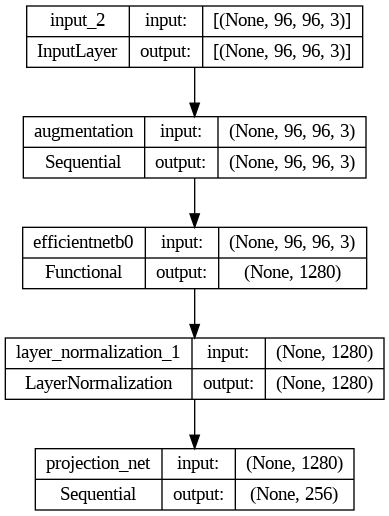

In [ ]:
encoding_net.summary()
tfk.utils.plot_model(encoding_net, show_shapes=True)

In [ ]:
#load dataset
load_data = np.load('clean_dataset_v0.npz', allow_pickle=True)

images = np.array(load_data['data'])#.astype(np.uint8))
y = np.array(load_data['labels'])
labels = {'healthy':0, 'unhealthy':1}

In [ ]:
X0 = images[np.where(y=='healthy')]
X1 = images[np.where(y=='unhealthy')]

X0 = X0[:100]
y0 = np.zeros((len(X0,)))
X1 = X1[:100]
y1 = np.ones((len(X1),))


In [ ]:
embeddings0 = encoding_net(preprocess_input(X0))
embeddings1 = encoding_net(preprocess_input(X1))

In [ ]:
print('Size embeddings left val pictures: ', embeddings0.shape)
print('Size embeddings righe val pictures: ', embeddings1.shape)

Size embeddings left val pictures:  (100, 256)
Size embeddings righe val pictures:  (100, 256)


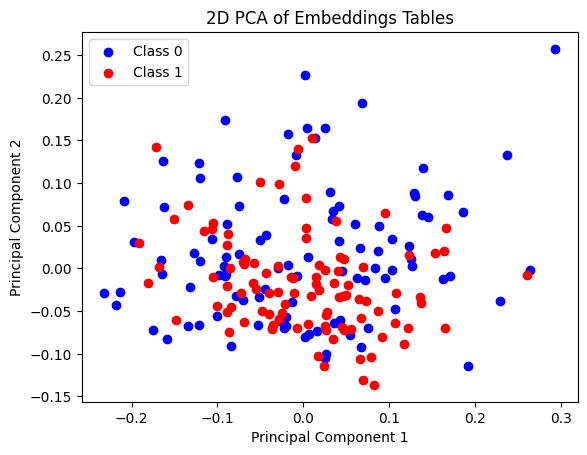

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Concatenate the two tables
combined_table = np.vstack([embeddings0, embeddings1])

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(combined_table)

# Separate the PCA results for each original table
pca_result_table1 = pca_result[:len(X0), :]
pca_result_table2 = pca_result[len(X0):, :]

# Plot the results with different colors
plt.scatter(pca_result_table1[:, 0], pca_result_table1[:, 1], c='blue', label='Class 0')
plt.scatter(pca_result_table2[:, 0], pca_result_table2[:, 1], c='red', label='Class 1')

plt.title('2D PCA of Embeddings Tables')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

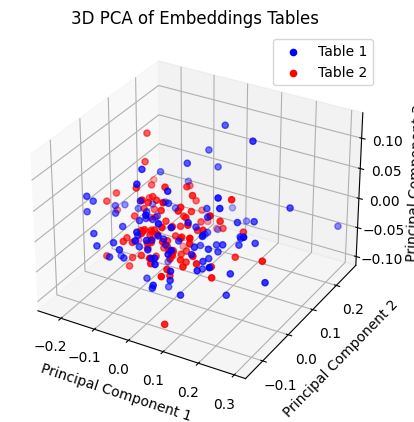

In [ ]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(combined_table)

# Separate the PCA results for each original table
pca_result_table1 = pca_result[:len(X0), :]
pca_result_table2 = pca_result[len(X0):, :]

# Plot the results in 3D with different colors
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pca_result_table1[:, 0], pca_result_table1[:, 1], pca_result_table1[:, 2], c='blue', label='Table 1')
ax.scatter(pca_result_table2[:, 0], pca_result_table2[:, 1], pca_result_table2[:, 2], c='red', label='Table 2')

ax.set_title('3D PCA of Embeddings Tables')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend()
plt.show()

## Train classification Network

In [ ]:
#load dataset
load_data = np.load('balanced_dataset_v1.npz', allow_pickle=True)

images = np.array(load_data['data'])#.astype(np.uint8))
y = np.array(load_data['labels'])
labels = {'healthy':0, 'unhealthy':1}

#normalize images
#images = images[:] / 255

In [ ]:
# Convert labels to categorical format using one-hot encoding
y_cat = tfk.utils.to_categorical(y)

# Split data into training and validation sets, maintaining class distribution
X_train, X_val, y_train, y_val = train_test_split(images, y_cat, random_state=seed, test_size=0.2, stratify=y_cat)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, random_state=seed, test_size=0.2, stratify=y_train)

del images
del y
del y_cat
del load_data

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 2)                 5311141   
                                                                 
Total params: 5311141 (20.26 MB)
Trainable params: 398850 (1.52 MB)
Non-trainable params: 4912291 (18.74 MB)
_________________________________________________________________


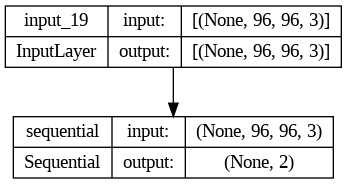

In [ ]:
l2_lambda = 5e-5
classification_net = tfk.Sequential([
    encoding_net,
    tfkl.BatchNormalization(),
    tfkl.Dense(dim, kernel_regularizer=tf.keras.regularizers.l2(l2_lambda), kernel_initializer=tfk.initializers.HeUniform(seed=seed), name='dense_out_1'),
    tfkl.BatchNormalization(name='BatchNorm_out_1'),
    tfkl.Activation('relu'),
    tfkl.Dense(dim, kernel_regularizer=tf.keras.regularizers.l2(l2_lambda), kernel_initializer=tfk.initializers.HeUniform(seed=seed), name='dense_out_2'),
    tfkl.BatchNormalization(name='BatchNorm_out_2'),
    tfkl.Activation('relu'),
    tfkl.Dense(dim, kernel_regularizer=tf.keras.regularizers.l2(l2_lambda), kernel_initializer=tfk.initializers.HeUniform(seed=seed), name='dense_out_3'),
    tfkl.BatchNormalization(name='BatchNorm_out_3'),
    tfkl.Activation('relu'),
    tfkl.Dense(dim, kernel_regularizer=tf.keras.regularizers.l2(l2_lambda), kernel_initializer=tfk.initializers.HeUniform(seed=seed), name='dense_out_4'),
    tfkl.BatchNormalization(name='BatchNorm_out_4'),
    tfkl.Activation('relu'),
    tfkl.Dense(dim, kernel_regularizer=tf.keras.regularizers.l2(l2_lambda), kernel_initializer=tfk.initializers.HeUniform(seed=seed), name='dense_out_5'),
    tfkl.BatchNormalization(name='BatchNorm_out_5'),
    tfkl.Activation('relu'),
    tfkl.Dense(dim, kernel_regularizer=tf.keras.regularizers.l2(l2_lambda), kernel_initializer=tfk.initializers.HeUniform(seed=seed), name='dense_out_6'),
    tfkl.BatchNormalization(name='BatchNorm_out_6'),
    tfkl.Activation('relu'),
    tfkl.Dense(units=2, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed=seed), name='output')
])

input = tfk.Input(input_shape)
output = classification_net(input)

classification_model = tfk.Model(inputs=input,outputs=output, name='model')
classification_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.AdamW(), metrics=['accuracy'])
classification_model.summary()
tfk.utils.plot_model(classification_model, show_shapes=True)

In [ ]:
classification_model.get_layer('sequential_6').layers[0].layers

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)

lr_patience = 5
lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss',# Metric to monitor (validation mean squared error in this case)
    patience=lr_patience,  # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.8,            # Factor by which the learning rate will be reduced (0.9 in this case)
    mode='min',            # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
    min_lr=1e-6            # Minimum learning rate
)

In [ ]:
# Train the model
history = classification_model.fit(
    x = preprocess_input(X_train*255.), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = batch_size,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255.), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [early_stopping, lr_scheduler]
).history

Epoch 1/200
16/16 [==============================] - 19s 372ms/step - loss: 0.9783 - accuracy: 0.6124 - val_loss: 0.8361 - val_accuracy: 0.6044 - lr: 0.0010
Epoch 2/200
16/16 [==============================] - 2s 152ms/step - loss: 0.7955 - accuracy: 0.6714 - val_loss: 0.9212 - val_accuracy: 0.5512 - lr: 0.0010
Epoch 3/200
16/16 [==============================] - 3s 162ms/step - loss: 0.7486 - accuracy: 0.7107 - val_loss: 0.8076 - val_accuracy: 0.6253 - lr: 0.0010
Epoch 4/200
16/16 [==============================] - 2s 157ms/step - loss: 0.7280 - accuracy: 0.7195 - val_loss: 0.7433 - val_accuracy: 0.6994 - lr: 0.0010
Epoch 5/200
16/16 [==============================] - 2s 143ms/step - loss: 0.7125 - accuracy: 0.7283 - val_loss: 0.7576 - val_accuracy: 0.6914 - lr: 0.0010
Epoch 6/200
16/16 [==============================] - 2s 143ms/step - loss: 0.6970 - accuracy: 0.7414 - val_loss: 0.7621 - val_accuracy: 0.6954 - lr: 0.0010
Epoch 7/200
16/16 [==============================] - 3s 160ms/s

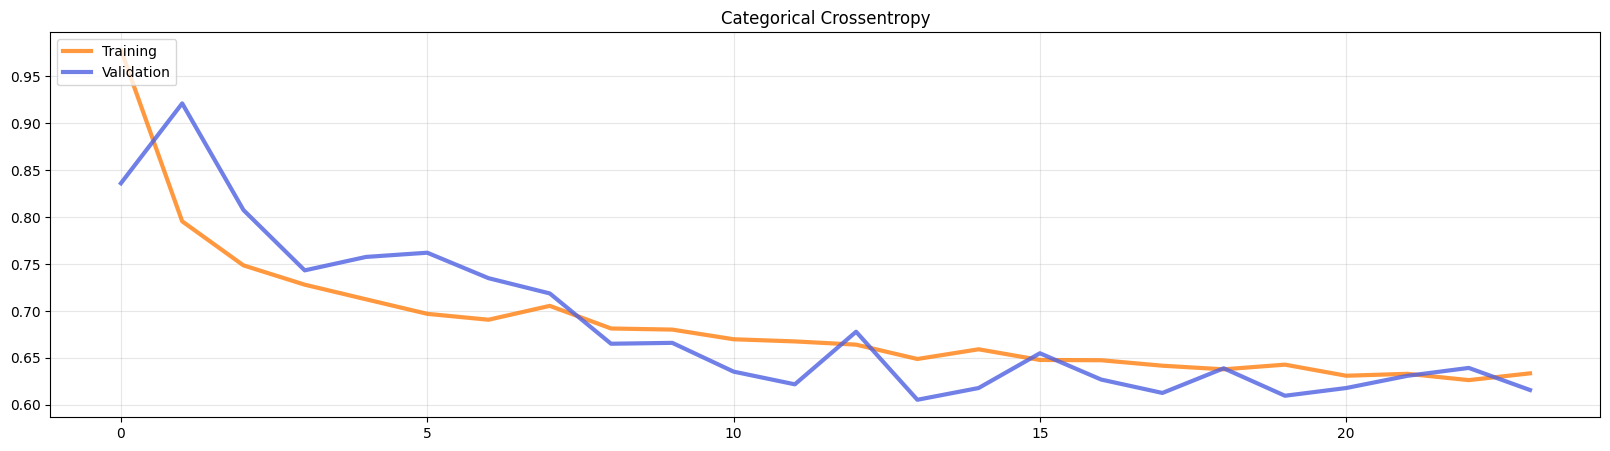

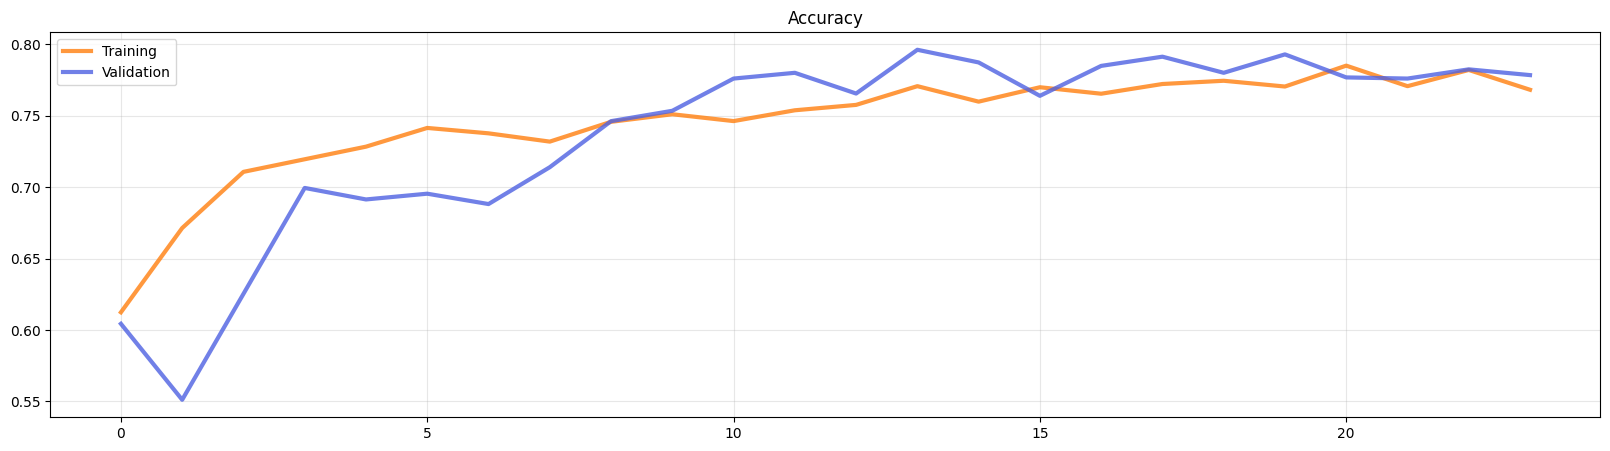

In [ ]:
# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [ ]:
# Evaluate the model on the test set
test_accuracy = classification_model.evaluate(preprocess_input(X_test*255),y_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

Test set accuracy 0.7966
